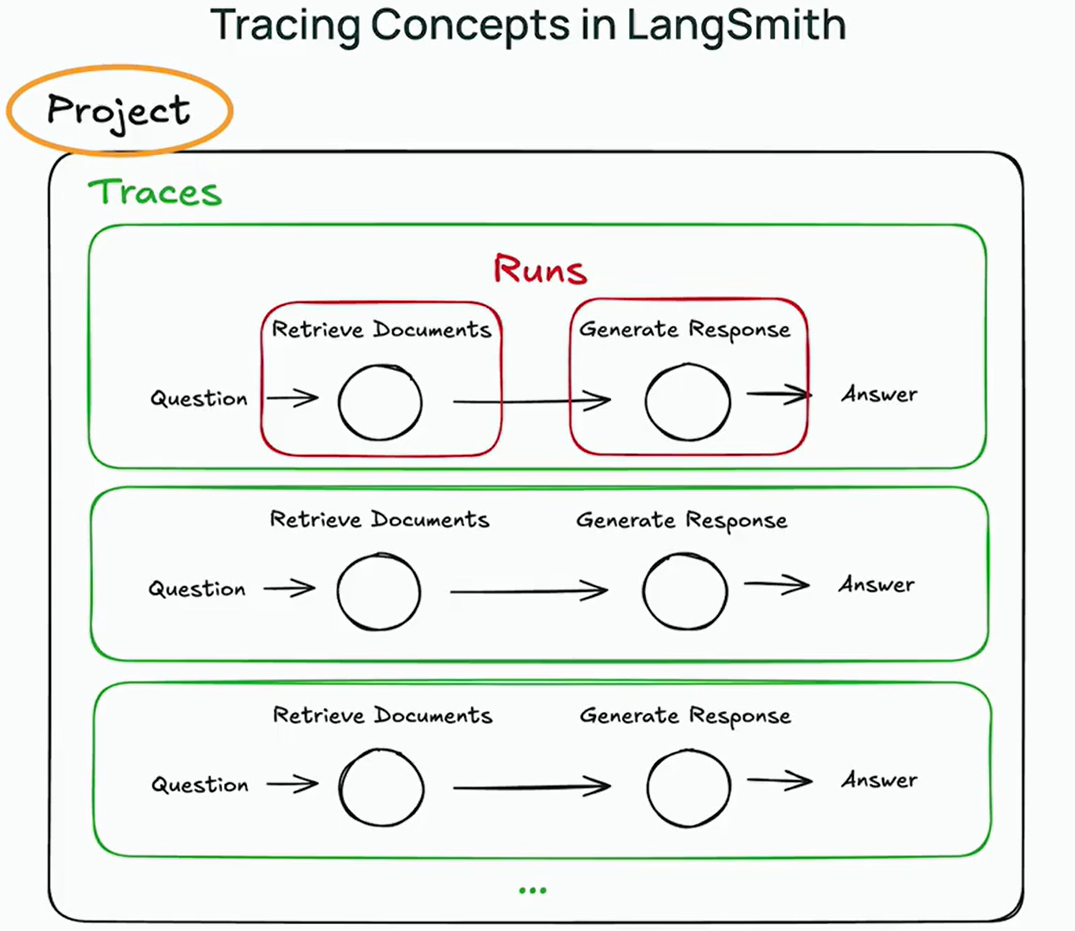
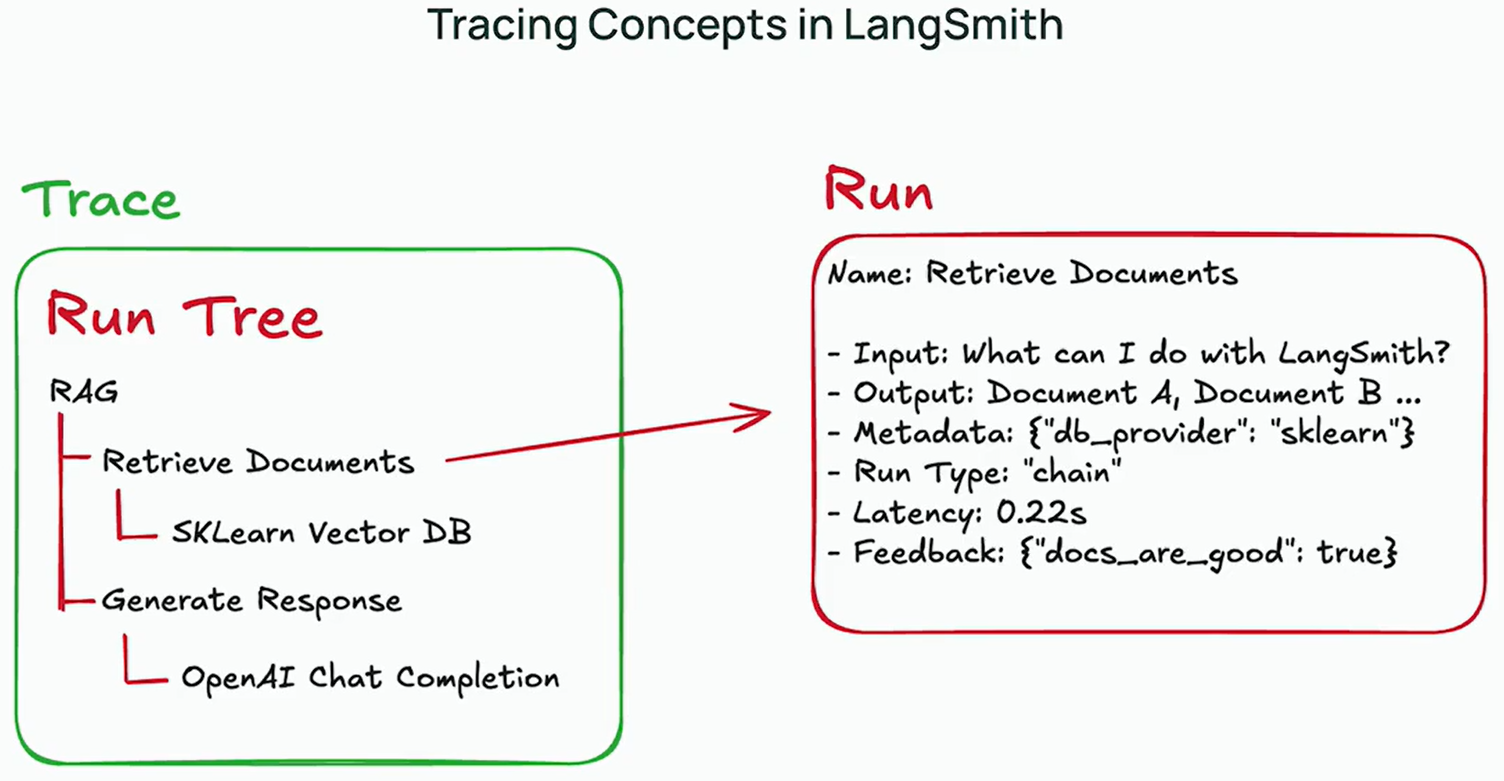
## **Tracing Basics**
### **Tracing with `@traceable`**
The `@traceable` decorator is an easy way to log function activity using the LangSmith Python SDK. Add @traceable above any function you want to monitor

When the decorated function is called:
- LangSmith automatically creates a run tree (a structured trace) for that execution.
- The function’s name, input arguments, and other details are sent to LangSmith.
- If the function succeeds or fails, the result or error is also logged.
- All this tracing is sent in real-time, without slowing down your app, since it runs in a background thread.

In [17]:
from dotenv import load_dotenv, find_dotenv
from langsmith import traceable
from openai import OpenAI
import nest_asyncio
from utils import get_vector_db_retriever
from langchain_core.messages import SystemMessage, HumanMessage
from typing import List

_ = load_dotenv(find_dotenv())

MODEL_PROVIDER    = "openai"
MODEL_NAME        = "gpt-4o-mini"
APP_VERSION       = 1.0
RAG_SYSTEM_PROMPT = """
    You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the latest question in the conversation. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
"""

openai_client = OpenAI()
nest_asyncio.apply()
retriever = get_vector_db_retriever()

@traceable
def retrieve_documents(question: str):
    return retriever.invoke(question)   # NOTE: This is a LangChain vector db retriever, so this .invoke() call will be traced automatically


def generate_response(question: str, documents):
    formatted_docs = "\n\n".join(doc.page_content for doc in documents)
    messages = [
        {
            "role": "system",
            "content": RAG_SYSTEM_PROMPT
        },
        {
            "role": "user",
            "content": f"Context: {formatted_docs} \n\n Question: {question}"
        }
    ]
    return call_openai(messages)

@traceable
def call_openai(
    messages: List[dict], model: str = MODEL_NAME, temperature: float = 0.0
) -> str:
    return openai_client.chat.completions.create(
        model = model,
        messages = messages,
        temperature = temperature,
    )

@traceable
def langsmith_rag(question: str):
    documents = retrieve_documents(question)
    response  = generate_response(question, documents)
    return response.choices[0].message.content

In [18]:
question = "How can I trace with the @traceable decorator?"
ai_answer = langsmith_rag(question)
print(ai_answer)

To trace with the @traceable decorator in Python, simply decorate any function with @traceable. Ensure that the LANGSMITH_TRACING environment variable is set to 'true' and the LANGSMITH_API_KEY is configured. You can also include attachments and set the dangerously_allow_filesystem flag if needed.


### **Adding Metadata**
LangSmith supports sending arbitrary metadata (a collection of key-value pairs) along with traces.
- Metadata can be used to store:
  - The app version that generated the run
  - The environment
  - Any other info you want to associate with the run
- Metadata is similar to tags: 
  - Filtering runs in the LangSmith UI
  - Grouping and analyzing related runs more effectively

In [ ]:
from langsmith import traceable

@traceable(
    metadata = {"vectordb": "sklearn"}
)
def retrieve_documents(question: str):
    return retriever.invoke(question)

@traceable
def generate_response(question: str, documents):
    formatted_docs = "\n\n".join(doc.page_content for doc in documents)
    messages = [
        {
            "role": "system",
            "content": RAG_SYSTEM_PROMPT
        },
        {
            "role": "user",
            "content": f"Context: {formatted_docs} \n\n Question: {question}"
        }
    ]
    return call_openai(messages)

@traceable(
    metadata = {"model_name": MODEL_NAME, "model_provider": MODEL_PROVIDER}
)
def call_openai(
    messages: List[dict], model: str = MODEL_NAME, temperature: float = 0.0
) -> str:
    return openai_client.chat.completions.create(
        model = model,
        messages = messages,
        temperature = temperature,
    )

@traceable
def langsmith_rag(question: str):
    documents = retrieve_documents(question)
    response = generate_response(question, documents)
    return response.choices[0].message.content

In [8]:
question = "How do I add Metadata to a Run with @traceable?"
ai_answer = langsmith_rag(question)
print(ai_answer)

To add metadata to a run with @traceable, you can use the appropriate method in your code to attach key-value pairs as metadata when initiating the trace. Ensure that you follow the guidelines provided in the LangSmith documentation for adding metadata. For detailed steps, refer to the section on adding metadata to your traces in the LangSmith documentation.


In [9]:
question = "How do I add metadata at runtime?"
ai_answer = langsmith_rag(question, langsmith_extra={"metadata": {"runtime_metadata": "foo"}})
print(ai_answer)

To add metadata at runtime, you can pass it in using the `langsmith_extra` parameter when calling your function. For example, you can include a `run_id` and any additional metadata like `user_id` in the function call, as shown in the code snippet: 

```python
rag("where did harrison work", langsmith_extra={"run_id": run_id, "metadata": {"user_id": "harrison"}})
``` 

This allows you to log dynamic information during the execution of your function.
